In [56]:
import os

import skimage
from skimage import data
from skimage.util import img_as_uint
import numpy as np
from numpy import matlib
from sklearn.datasets import load_svmlight_file
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
from scipy.signal import convolve2d

import scfw.poisson as ps
from scfw.scopt import scopt

In [2]:
%matplotlib inline

## Data load

In [41]:
def blur_image(im, scale_factor=10):
    blur = np.array([0.011178978813925, 0.050100707167907, 0.082602101584847, 0.050100707167907, 0.011178978813925,
                     0.050100707167907, 0.224535791730617, 0.370196935859762, 0.224535791730617, 0.050100707167907,
                     0.082602101584847, 0.370196935859762, 0.610351562500000, 0.370196935859762, 0.082602101584847,
                     0.050100707167907, 0.224535791730617, 0.370196935859762, 0.224535791730617, 0.050100707167907,
                     0.011178978813925, 0.050100707167907, 0.082602101584847, 0.050100707167907, 0.011178978813925])
    blur *= 1e-4

    im = img_as_uint(cam)
    im *= scale_factor
    im_star = convolve2d(im, blur.reshape(1, -1), mode='same')
    y = np.random.poisson(im_star)
    y = np.round(y)
    return im_star, y

In [45]:
im = data.camera()
im_star, y = blur_image(im, 1)

Text(0.5, 1.0, 'Noise')

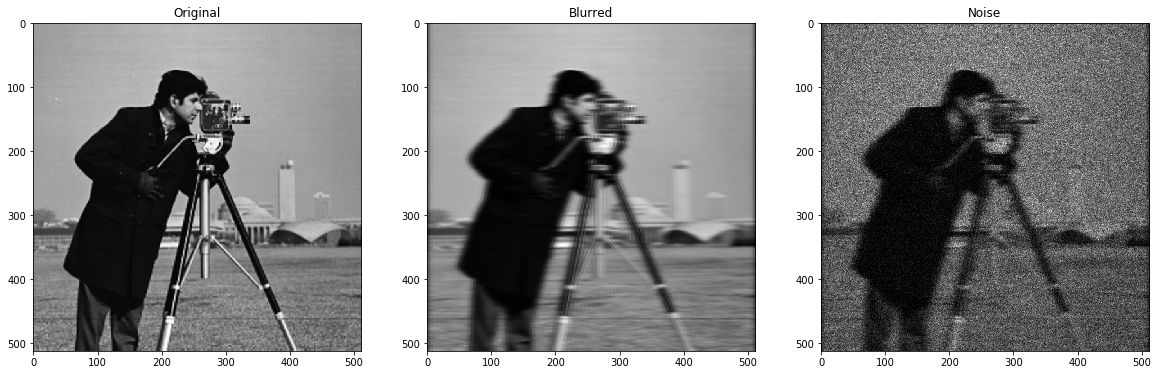

In [50]:
plt.figure(figsize=(20, 7))

plt.subplot(131)
imshow(im, 'gray')
plt.title('Original')

plt.subplot(132)
imshow(im_star, 'gray')
plt.title('Blurred')

plt.subplot(133)
imshow(y, 'gray')
plt.title('Noise')

In [53]:
y.sum()

array([[ 9, 11,  7, ..., 13, 14,  5],
       [ 7, 12, 10, ...,  3, 18, 10],
       [ 9, 12,  8, ..., 11, 10,  8],
       ...,
       [ 9,  6, 12, ...,  6, 10,  6],
       [ 8,  3, 11, ..., 10, 12,  7],
       [ 7, 11,  5, ...,  6, 10,  4]])

## Data preprocessing

In [57]:
# # multiplicative multiplication of the structure of the recognizable structure
# W = matlib.repmat(y, 1, W.shape[1]) * W
# # summation of feature descriptions
# sA = np.sum(W, 1)
# # if the sum of the string is negative, invert it
# W[sA < 0, :] = -W[sA < 0, :]
# # zero row deletion
# W = W[sA != 0, :]
# # W = scipy.sparse.csr_matrix(W)

# Bias = 1
# b = (Bias * y).squeeze()
# b = np.abs(b)
# if (b.any == 0):
#     print(' Input parameter y error')

# y = b
y = np.sum(axis=1)
W = im
N, n = W.shape

NameError: name 'W' is not defined

## Parameters initialization

In [4]:
lam =  np.sqrt(N)/2
#first set of parameters
Mf = max(2 / np.sqrt(y))
nu = 3
I = np.eye(n)
Iv = np.ones(n)
#running parameters
x0 = np.ones(n) / n
terminate_tol = 1e-10
M = ps.poisson(W, y, lam, x0)[0] / lam

FW_params={
    'iter_FW': 50000,
    'line_search_tol': 1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'estimate', #estimate L
    'use_two_phase': True,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol': 1e-2,
    'conj_grad_iter': 100,
}

## Auxilary functions

In [5]:
func_x = lambda x: ps.poisson(W, y, lam, x)
grad_x = lambda x, dot_product: ps.grad_poisson(W, y, lam, x, dot_product)
grad_beta = lambda x, s, beta, dot_product, dot_product_s: ps.grad_poisson(W, y, lam, (1 - beta) * x + beta * s, (1 - beta) * dot_product + beta * dot_product_s)
hess_mult_x = lambda x, dot_product: ps.hess_mult(W, y, x, dot_product)
hess_mult_vec_x = lambda s, dot_product: ps.hess_mult_vec(W, y, s, dot_product)
extra_func = lambda x: W @ x
linear_orcale = lambda grad: ps.linear_oracle_full_simplex(grad, M)
prox_func = lambda x, L: np.maximum(x, 0) #used for SCOPT

## Run SCOPT

In [6]:
 x, alpha_hist, Q_hist, time_hist, grad_hist = scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          x0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=10)
    
results[problem_name]['scopt'] = {
    'x': x,
    'alpha_hist': alpha_hist,
    #'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
    'grad_hist': grad_hist
}

iter =    1, stepsize = 6.185e-03, rdiff = 9.762e-02 , f = 74848

iter =   10, stepsize = 6.230e-03, rdiff = 9.565e-02 , f = 73424

iter =   20, stepsize = 6.280e-03, rdiff = 9.366e-02 , f = 71853.2

iter =   30, stepsize = 6.328e-03, rdiff = 9.237e-02 , f = 70294.9

iter =   40, stepsize = 6.384e-03, rdiff = 9.085e-02 , f = 68749.9

Fista err = 9.997e-06; Subiter = 982; subproblem converged!

Fista err = 9.995e-06; Subiter = 894; subproblem converged!

Fista err = 9.996e-06; Subiter = 899; subproblem converged!

Fista err = 9.988e-06; Subiter = 794; subproblem converged!

Fista err = 9.991e-06; Subiter = 916; subproblem converged!

Fista err = 9.994e-06; Subiter = 806; subproblem converged!

Fista err = 9.995e-06; Subiter = 933; subproblem converged!

iter =   50, stepsize = 6.446e-03, rdiff = 9.017e-02 , f = 67218.9

Fista err = 9.993e-06; Subiter = 809; subproblem converged!

Fista err = 9.992e-06; Subiter = 696; subproblem converged!

Fista err = 9.993e-06; Subiter = 822; subproble